In [208]:
import matplotlib as mplot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import glob
import os

In [209]:
def compute_distances_single_run(run, tid, n_threads):
    indices = np.where(run == tid)[0] # np.where() returns a tuple
    if len(indices) > 0 and indices[0] > n_threads: 
        np.insert(indices,0,tid)
    return np.diff(indices).tolist()   

In [210]:
def compute_gaps_and_frequencies(data, n_threads, total_runs):
    frequencies = []
    gaps = [] # stores all distances between occurences of the same thread ID for all threads and all runs
    for run in range(total_runs):
            for tid in range(n_threads):
                gaps += compute_distances_single_run(data[run], tid, n_threads)

    return frequencies, gaps

In [211]:
n_threads = 2
total_runs = 30
file = "out_2_3.txt"
data = np.loadtxt(os.path.join(cwd + "/output", file), dtype=int)
frequencies, gaps = compute_gaps_and_frequencies(data, n_threads, total_runs)

In [ ]:
def compute_distances_single_row(row, th_id,n_threads):
    row_values = row.astype(int)                # Convert the row values to integers
    indices = np.where(row_values == th_id)[0] # Find the indices where the number occurs in the row
    if len(indices)>0 and indices[0]>n_threads: np.insert(indices,0,th_id)
    distances = np.diff(indices)                # Compute the distances between consecutive occurrences
    return distances.tolist()

for i in range(30):
    for j in range(2):
        print("row", i, "tid", j, max(compute_distances_single_row(data[i], j, 2)))

8 threads using tree lock
30 runs with 64 lock acquisitions

2 threads using tree lock
30 runs with 4 lock acquisitions

4 threads using tree lock
30 runs with 16 lock acquisitions



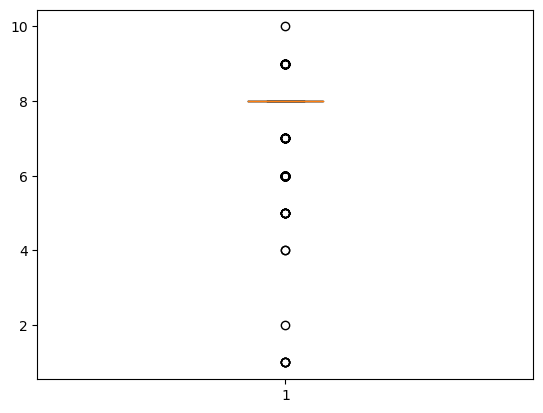

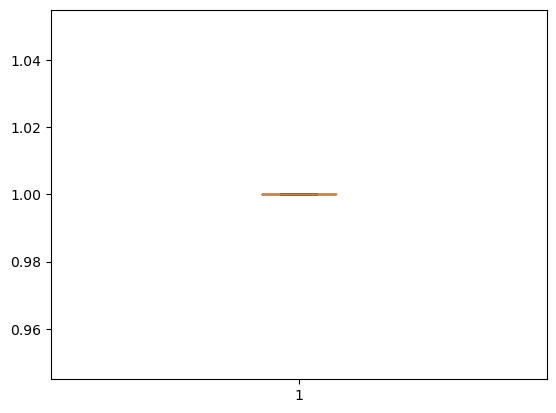

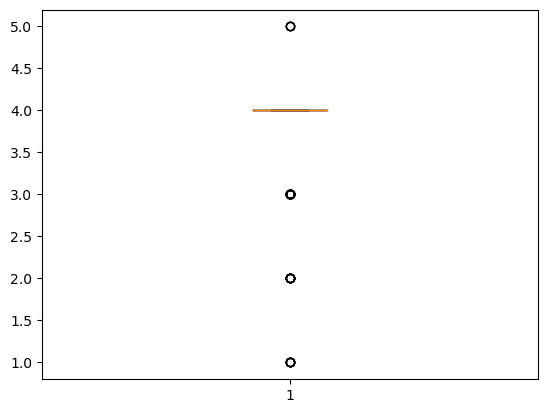

In [212]:
# Get paths to all output files
cwd = os.getcwd()
data_src = glob.glob(cwd + "/output/out_*")
file_names = [file_name.split('/')[-1] for file_name in data_src]
lock_dict = {1: 'omp', 2: 'filter', 3: 'tree', 4: 'block-woo'}

freq_dict = {}
gaps_dict = {}

for file in file_names:
    data = np.loadtxt(os.path.join(cwd + "/output", file), dtype=int)

    numbers = re.findall(r'\d+', file)
    n_threads = int(numbers[0])
    which_lock = int(numbers[1])
    total_runs = data.shape[0]

    print(n_threads, "threads using", lock_dict[which_lock], "lock")
    print(total_runs, "runs with", data.shape[1], "lock acquisitions\n") 

    frequencies, gaps = compute_gaps_and_frequencies(data, n_threads, total_runs)

    plt.figure()
    plt.boxplot(gaps)

    freq_dict[n_threads] = frequencies
    gaps_dict[n_threads] = gaps

[Text(1, 0, '2'), Text(2, 0, '4'), Text(3, 0, '8')]

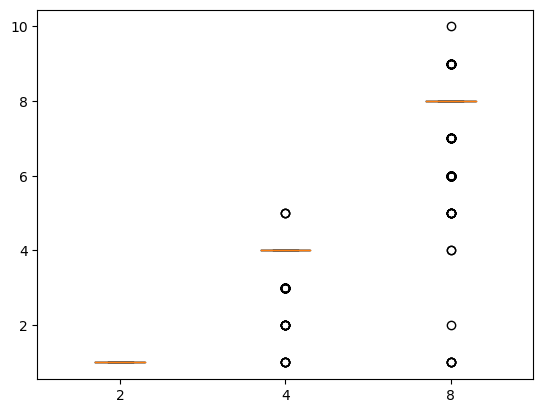

In [213]:
gaps_dict = dict(sorted(gaps_dict.items()))

fig, ax = plt.subplots()
ax.boxplot(gaps_dict.values())
ax.set_xticklabels(gaps_dict.keys())